# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-07-09

### Inputs 
 - `1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC data
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
The project Google Drive, at: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, there are more permutations of which stations to consider (closest in elevation, or consensus amongst those in the same ecosystem), but that would be combinatorial and there were little indicators that these would have yielded resutls.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy.stats as stats

In [4]:
import sklearn.metrics as metrics

In [5]:
sns.set(style="darkgrid")

In [6]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

The cleaned data set, `1.0-rec-initial-data-cleaning.txt`, drops circles with "impossible" temperture, wind, and snow values, which we still find valuable here since we assume that even mistaken/erroneous temp/wind data can still have valuable precipitation data

In [7]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a rain value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [8]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [38]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
# drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',
                             ]]

## Data Prep

#### stations

In [40]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

#### volunteer records

`[am|pm]_rain` are strings containing `1`:`4`, for heavy, light, none, or unknow rain
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day  
If both am and pm are `3`, then there was no precipitation that day  
Else, we mark `nan`

In [41]:
for c in ['am_rain', 'pm_rain']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [42]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

## comparing stations and circles

In [43]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [44]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [58]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## data clean up

In [61]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [63]:
# once again dump excess data
prcp_data.drop(columns=['am_rain', 'pm_rain','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',], inplace=True)

In [64]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

In [65]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [66]:
station_obs

c_name country_state      c_lat  \
c_id    count_date s_id                                                    
87ymwsn 1968-12-26 USC00519130   Kaua'i: Waimea         US-HI  22.083300   
87ysunb 1971-12-27 US1HIKI0004   Kaua'i: Lihu'e         US-HI  21.966700   
                   US1HIKI0014   Kaua'i: Lihu'e         US-HI  21.966700   
                   US1HIKI0018   Kaua'i: Lihu'e         US-HI  21.966700   
                   USC00510006   Kaua'i: Lihu'e         US-HI  21.966700   
...                                         ...           ...        ...   
zcpkrwz 1979-12-18 USW00045702  Amchitka Island         US-AK  51.409713   
        1992-12-20 USC00500252  Amchitka Island         US-AK  51.409713   
                   USW00045702  Amchitka Island         US-AK  51.409713   
        1993-12-28 USC00500252  Amchitka Island         US-AK  51.409713   
                   USW00045702  Amchitka Island         US-AK  51.409713   

                                     c_lon    s_lat     s_lon s_rain c_rain  \
c_id    count_date s_id                                                       
87ymwsn 1968-12-26 USC00519130 -159.666700  22.1167 -159.6167   <NA>  False   
87ysunb 1971-12-27 US1HIKI0004 -159.433300  21.9249 -159.4983   <NA>   True   
                   US1HIKI0014 -159.433300  21.9055 -159.5150   <NA>   True   
                   US1HIKI0018 -159.433300  21.9075 -159.5181   <NA>   True   
                   USC00510006 -159.433300  21.9500 -159.4333   <NA>   True   
...                                    ...      ...       ...    ...    ...   
zcpkrwz 1979-12-18 USW00045702  179.284881  51.3833  179.2500   <NA>  False   
        1992-12-20 USC00500252  179.284881  51.3833  179.2833   <NA>   <NA>   
                   USW00045702  179.284881  51.3833  179.2500   <NA>   <NA>   
        1993-12-28 USC00500252  179.284881  51.3833  179.2833   <NA>   <NA>   
                   USW00045702  179.284881  51.3833  179.2500   <NA>   <NA>   

                                    distance  d_elev  same_ecosys  same_nlcd  
c_id    count_date s_id                                                       
87ymwsn 1968-12-26 USC00519130   6352.278644   36.16         <NA>       <NA>  
87ysunb 1971-12-27 US1HIKI0004   8159.889753   43.84         <NA>       <NA>  
                   US1HIKI0014  10834.614107   11.26         <NA>       <NA>  
                   US1HIKI0018  10950.027151   17.34         <NA>       <NA>  
                   USC00510006   1857.479921   35.96         <NA>       <NA>  
...                                      ...     ...          ...        ...  
zcpkrwz 1979-12-18 USW00045702   3806.612762     NaN         <NA>       <NA>  
        1992-12-20 USC00500252   2939.869435     NaN         <NA>       <NA>  
                   USW00045702   3806.612762     NaN         <NA>       <NA>  
        1993-12-28 USC00500252   2939.869435     NaN         <NA>       <NA>  
                   USW00045702   3806.612762     NaN         <NA>       <NA>  

[412105 rows x 12 columns]

# Rain Analysis
All the below analyses use the fraction-agreement threshold defined above, and are only for stations within the above-defined distance threshold

In [19]:
def rain_calc(dfg):
    is_na = dfg.s_rain.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_rain.size + 0
    num_notna = dfg.s_rain.count() + 0
    num_true = dfg.s_rain.sum() + 0

    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        # theres a sinister bug where stations present twice for the same circle, so dims are not dropped for `dfg.s_rain[...idxmin()]`
        # in that case, the result is a series
        # so,force retention as dataframe and this convoluted bs :/
        # examples: ('9yuvef2', '2010-12-26'), ('9z70n7m', '2008-12-27'), ('djvyywp', '2013-12-24'), ('dp9mpqu', '2012-12-15'), ('dpe0e5b', '2010-12-26'), ...
        'rain_closest' : dfg.loc[[dfg.distance.idxmin()]].s_rain.iloc[0] if (num > 0) else pd.NA,
        'rain_closest_notna' : dfg.loc[[dfg.loc[~is_na, 'distance'].idxmin()]].s_rain.iloc[0] if (num_notna > 0) else pd.NA,
    })


In [20]:
station_rain = g.apply(rain_calc)
station_rain = station_rain.join(circle_obs)

In [21]:
station_rain['consensus'] = np.where((station_rain.p >= (1-AGREEMENT_THRESHOLD)) & (station_rain.p <= AGREEMENT_THRESHOLD), 
                                     pd.NA, station_rain.p >= AGREEMENT_THRESHOLD)

In [113]:
for c in ['consensus', 'c_rain', 'rain_closest', 'rain_closest_notna']:
    station_rain[c] = station_rain[c].astype('boolean')

## total stats

### the number of stations per circle

In [22]:
station_rain.num.describe()

count    45928.000000
mean         1.785860
std          1.786032
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         41.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

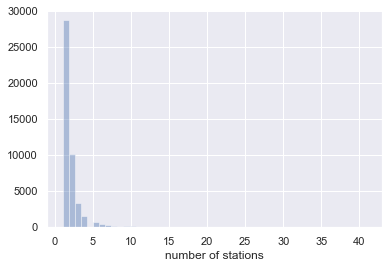

In [74]:
sns.distplot(station_rain.num, kde=False).set_xlabel("number of stations")

### the number of non-NaN stations per circle

In [24]:
station_rain.num_notna.describe()

count    45928.000000
mean         1.664540
std          1.708073
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         41.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

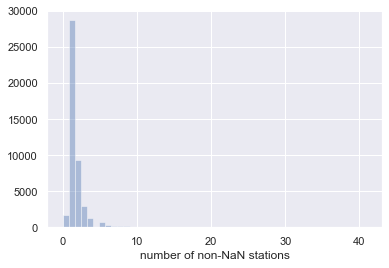

In [25]:
sns.distplot(station_rain.num_notna, kde=False).set_xlabel("number of non-NaN stations")

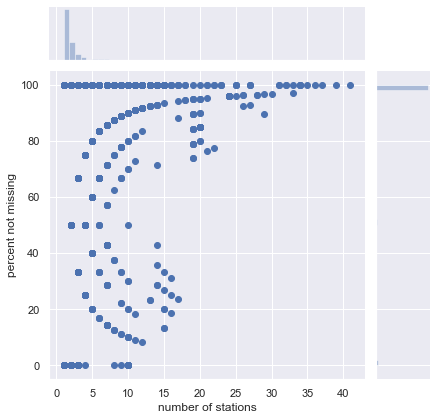

In [91]:
sns.jointplot(station_rain.num, station_rain.num_notna/station_rain.num * 100).set_axis_labels("number of stations", 'percent not missing')

### percent of circles where all stations are missing data

In [77]:
(station_rain.num_notna == 0).sum() / len(station_rain) * 100

3.6143529001916046

### percent of circles where no stations are missing data

In [78]:
(station_rain.num_notna == station_rain.num).sum() / len(station_rain) * 100

90.14979968646577

In [80]:
(station_rain.num_notna / station_rain.num >= 0.5).sum() / len(station_rain) * 100

95.96542414213552

### location, location, location

what percent of circles had the closest station as NaN?

In [81]:
station_rain.rain_closest.isna().sum() / len(station_rain) * 100

5.822156418742379

what percent had the average value differ from the closest value (ignoring NaNs)?

In [82]:
# use kleene logical indexing to skip over NAs
(station_rain.rain_closest_notna ^ station_rain.consensus).sum() / len(station_rain) * 100

3.165824769203972

In [83]:
prcp_data.distance.describe()

count    82021.000000
mean      7681.614573
std       3988.117271
min          0.000000
25%       4424.482939
50%       7651.567462
75%      10984.505814
max      14998.957181
Name: distance, dtype: float64

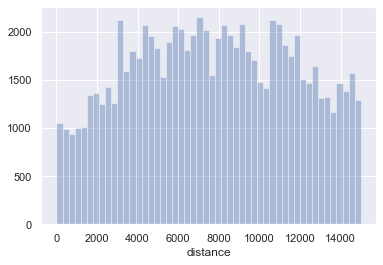

In [84]:
sns.distplot(prcp_data.distance, kde=False)

### overall consensus of stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for rain)

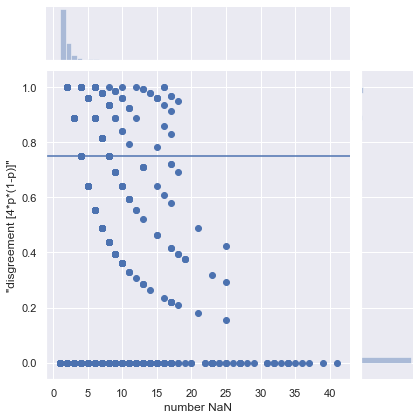

In [32]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p))
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

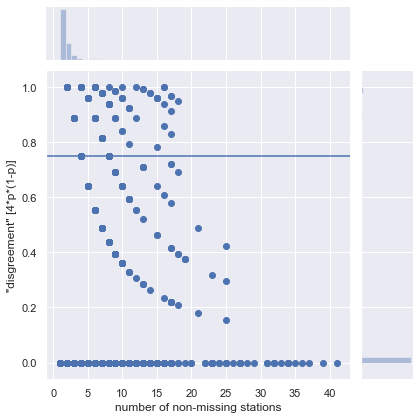

In [93]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p))
p.set_axis_labels("number of non-missing stations", '"disgreement" [4*p*(1-p)]')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [34]:
station_rain.consensus.isna().sum() / len(station_rain) * 100

6.198832955931023

## the MISSING

In [35]:
station_rain_na_circle_idx = station_rain.c_rain.isna()

### percent of circles with missing rain observation

In [36]:
station_rain_na_circle_idx.sum() / len(station_rain) * 100

40.75074028914823

### percent of circles with both volunteer and all station data are missing

In [86]:
# joint
(station_rain_na_circle_idx & (station_rain.num_notna == 0)).sum() / len(station_rain) * 100

0.8796376937815712

In [87]:
# conditional 
(station_rain_na_circle_idx & (station_rain.num_notna == 0)).sum() / station_rain_na_circle_idx.sum() * 100

2.1585808933532804

In [88]:
# population
(station_rain.num_notna == 0).sum() / len(station_rain) * 100

3.6143529001916046

correlation between the two

In [89]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(station_rain_na_circle_idx, station_rain.num_notna == 0))
g, p

(191.46019126281416, 1.5261917003591202e-43)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

### percent of circles with both volunteer and the closest station data are missing

In [41]:
# joint
(station_rain_na_circle_idx & station_rain.rain_closest.isna()).sum()  / len(station_rain) * 100

1.2911513673576032

In [42]:
# conditional 
(station_rain_na_circle_idx & station_rain.rain_closest.isna()).sum() / station_rain_na_circle_idx.sum() * 100

3.168412053857662

In [43]:
# population
station_rain.rain_closest.isna().sum() / len(station_rain) * 100

5.822156418742379

In [44]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(station_rain_na_circle_idx, station_rain.rain_closest.isna()))
g, p

(404.8935163604215, 4.739075447736361e-90)

if the circle is missing data, it is much **less** likely that the closes station will have missing data, when compared to the general population

### number of stations for circles with missing data

In [45]:
actl = pd.crosstab(station_rain_na_circle_idx, station_rain.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(1711.4952301340618, 0.0)

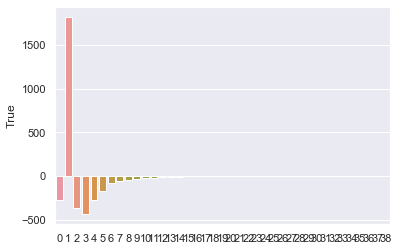

In [46]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### disagreement

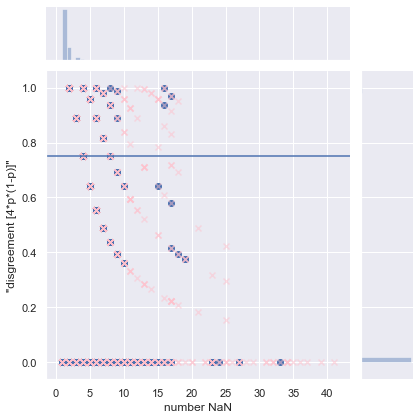

In [47]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.loc[station_rain_na_circle_idx, 'num_notna'], 
                  4 * station_rain.loc[station_rain_na_circle_idx, 'p'] * (1 - station_rain.loc[station_rain_na_circle_idx, 'p']))
p.ax_joint.scatter(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [48]:
# joint
station_rain.loc[station_rain_na_circle_idx, 'consensus'].isna().sum() / len(station_rain) * 100

1.7048423619578472

In [49]:
# conditional
station_rain.loc[station_rain_na_circle_idx, 'consensus'].isna().sum() / station_rain_na_circle_idx.sum() * 100

4.183586236375294

In [94]:
# population
station_rain.consensus.isna().sum() / len(station_rain) * 100

6.198832955931023

In [51]:
actl = pd.crosstab(station_rain_na_circle_idx, station_rain.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(220.04736394079939, 8.831862781062105e-50)

In [52]:
actl - expctd

consensus,False,True
c_rain,,
False,-377.173576,377.173576
True,377.173576,-377.173576


missing your rain data imples the stations are more likely to consense

# the found

### based on the closest station

In [115]:
actl = pd.crosstab(station_rain['rain_closest_notna'], station_rain['c_rain'])
actl

c_rain,False,True
rain_closest_notna,,
False,14789,2251
True,4705,4211


In [116]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
rain_closest_notna,,
False,0.758644,0.348344
True,0.241356,0.651656


In [117]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
rain_closest_notna,,
False,0.569772,0.086724
True,0.181268,0.162236


In [118]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.7320080135614117

In [119]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.6516558341070876

In [120]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.47229699416778825

In [121]:
## F1
2 * pr * re / (pr + re)

0.5476654961633503

### based on the stations' consensus

In [122]:
actl = pd.crosstab(station_rain.consensus, station_rain.c_rain)
actl

c_rain,False,True
consensus,,
False,15011,2249
True,4015,3873


In [123]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
consensus,,
False,0.788973,0.367364
True,0.211027,0.632636


In [124]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
consensus,,
False,0.596906,0.089431
True,0.159655,0.154008


In [125]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.7509145856529347

In [126]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.6326363933355112

In [127]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.49099898580121704

In [128]:
## F1
2 * pr * re / (pr + re)

0.5528907922912205

### did atleast one station aggree?

In [152]:
actl = pd.crosstab(station_rain.num_true >= 1, station_rain.c_rain)
actl

c_rain,False,True
num_true,,
False,14887,2205
True,5541,4579


In [153]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
num_true,,
False,0.728755,0.325029
True,0.271245,0.674971


In [154]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
num_true,,
False,0.547075,0.081030
True,0.203623,0.168271


In [155]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.7153461708069969

In [156]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.6749705188679245

In [157]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.4524703557312253

In [158]:
## F1
2 * pr * re / (pr + re)

0.5417652626597255